In [1]:
import os
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
# from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import models as M
import trainer as T

from torch.utils.tensorboard import SummaryWriter

from plot_lib import set_default


In [2]:
set_default()

In [3]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    # else "mps"
    # if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [4]:
DATADIR = "/Users/mghifary/Work/Code/AI/data"
MODEL_DIR = "models"
MODEL_SUFFIX = "convnet-exp2"
BATCH_SIZE = 64
EPOCHS = 25

In [5]:
# set tensorboard "log_dir" to "logs"
writer = SummaryWriter(f"logs/fashion-mnist_{MODEL_SUFFIX}")

In [6]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root=DATADIR,
    train=True,
    download=True,
    transform=transform,
)

test_data = datasets.FashionMNIST(
    root=DATADIR,
    train=False,
    download=True,
    transform=transform,
)

In [7]:
# Create data loaders
train_dataloader = DataLoader(
    train_data, 
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=False,
)

for X, y in train_dataloader:
    [_, c, dx1, dx2] = X.shape
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape}, {y.dtype}")
    break

num_classes = len(torch.unique(train_data.train_labels))

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]), torch.int64


/opt/homebrew/lib/python3.11/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


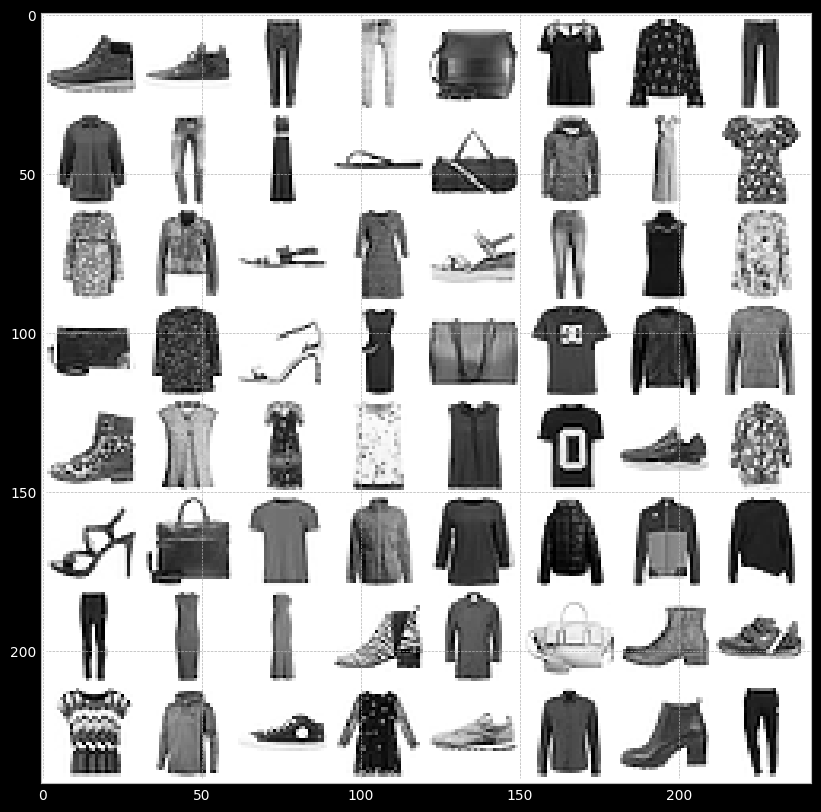

In [8]:
# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# create grid of images
img_grid = torchvision.utils.make_grid(images)

        
# show images
matplotlib_imshow(img_grid, one_channel=True)

In [9]:
# write to tensorboard
writer.add_image("fashion_mnist_images", img_grid)

In [10]:
# Initialize model
# model = M.NeuralNetwork(c, dx1, dx2, num_classes)
# model = M.ResNet(1, 18, M.ResidualBlock, num_classes=num_classes)
# model = M.TinyResnet(c, M.ResidualBlock, num_classes=num_classes)
# model = M.TinyResnetV2(c, M.ResidualBlock, num_classes=num_classes)
model = M.ConvNet(c, dx1, dx2, num_classes=num_classes)
model = model.to(device)
print(model)

ConvNet(
  (convnet): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=3136, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [11]:
# Optimizer and loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

In [12]:
# Inspect model using Tensorboard
writer.add_graph(model, images)

In [13]:
checkpoint_dir = os.path.join(MODEL_DIR, "fashion-mnist")

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir, f"{MODEL_SUFFIX}.pth")

T.fit(
    model, 
    train_dataloader, 
    test_dataloader, 
    loss_fn, 
    optimizer, 
    n_epochs=EPOCHS, 
    checkpoint_path=checkpoint_path, 
    writer=writer
)
 
print("Done!")

Epoch 1
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.02batch/s, loss=0.448]


Test Performance: 
 Accuracy: 86.41%, Avg loss: 0.3799 

Test Performance: 
 Accuracy: 85.75%, Avg loss: 0.4024 

Elapsed time: 27.59 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 2
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.53batch/s, loss=0.215]


Test Performance: 
 Accuracy: 89.00%, Avg loss: 0.3115 

Test Performance: 
 Accuracy: 87.85%, Avg loss: 0.3389 

Elapsed time: 27.16 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 3
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.60batch/s, loss=0.218] 


Test Performance: 
 Accuracy: 89.66%, Avg loss: 0.2873 

Test Performance: 
 Accuracy: 88.57%, Avg loss: 0.3209 

Elapsed time: 27.11 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 4
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.60batch/s, loss=0.229] 


Test Performance: 
 Accuracy: 90.69%, Avg loss: 0.2594 

Test Performance: 
 Accuracy: 89.22%, Avg loss: 0.2978 

Elapsed time: 27.11 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 5
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.42batch/s, loss=0.178] 


Test Performance: 
 Accuracy: 91.16%, Avg loss: 0.2427 

Test Performance: 
 Accuracy: 89.68%, Avg loss: 0.2844 

Elapsed time: 27.25 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 6
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.59batch/s, loss=0.402] 


Test Performance: 
 Accuracy: 91.76%, Avg loss: 0.2283 

Test Performance: 
 Accuracy: 89.84%, Avg loss: 0.2801 

Elapsed time: 27.12 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 7
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.56batch/s, loss=0.164] 


Test Performance: 
 Accuracy: 91.95%, Avg loss: 0.2190 

Test Performance: 
 Accuracy: 90.28%, Avg loss: 0.2704 

Elapsed time: 27.15 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 8
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.36batch/s, loss=0.152] 


Test Performance: 
 Accuracy: 92.84%, Avg loss: 0.1979 

Test Performance: 
 Accuracy: 90.67%, Avg loss: 0.2599 

Elapsed time: 27.30 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 9
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.66batch/s, loss=0.114] 


Test Performance: 
 Accuracy: 92.86%, Avg loss: 0.1962 

Test Performance: 
 Accuracy: 90.37%, Avg loss: 0.2654 

Elapsed time: 27.07 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 10
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.13batch/s, loss=0.299] 


Test Performance: 
 Accuracy: 93.04%, Avg loss: 0.1862 

Test Performance: 
 Accuracy: 90.48%, Avg loss: 0.2607 

Elapsed time: 27.48 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 11
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.03batch/s, loss=0.206] 


Test Performance: 
 Accuracy: 94.01%, Avg loss: 0.1645 

Test Performance: 
 Accuracy: 91.23%, Avg loss: 0.2527 

Elapsed time: 27.57 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 12
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.53batch/s, loss=0.109] 


Test Performance: 
 Accuracy: 94.38%, Avg loss: 0.1561 

Test Performance: 
 Accuracy: 91.51%, Avg loss: 0.2436 

Elapsed time: 27.17 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 13
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.45batch/s, loss=0.134] 


Test Performance: 
 Accuracy: 94.62%, Avg loss: 0.1485 

Test Performance: 
 Accuracy: 91.40%, Avg loss: 0.2504 

Elapsed time: 27.23 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 14
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.02batch/s, loss=0.255] 


Test Performance: 
 Accuracy: 94.28%, Avg loss: 0.1512 

Test Performance: 
 Accuracy: 90.94%, Avg loss: 0.2590 

Elapsed time: 27.57 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 15
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.58batch/s, loss=0.23]  


Test Performance: 
 Accuracy: 95.23%, Avg loss: 0.1318 

Test Performance: 
 Accuracy: 91.59%, Avg loss: 0.2485 

Elapsed time: 27.13 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 16
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.64batch/s, loss=0.0549]


Test Performance: 
 Accuracy: 95.73%, Avg loss: 0.1179 

Test Performance: 
 Accuracy: 91.75%, Avg loss: 0.2418 

Elapsed time: 27.08 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 17
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 33.80batch/s, loss=0.0736]


Test Performance: 
 Accuracy: 95.76%, Avg loss: 0.1190 

Test Performance: 
 Accuracy: 91.49%, Avg loss: 0.2556 

Elapsed time: 27.75 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 18
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.64batch/s, loss=0.129] 


Test Performance: 
 Accuracy: 95.49%, Avg loss: 0.1185 

Test Performance: 
 Accuracy: 91.06%, Avg loss: 0.2638 

Elapsed time: 27.08 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 19
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.42batch/s, loss=0.179] 


Test Performance: 
 Accuracy: 96.44%, Avg loss: 0.1004 

Test Performance: 
 Accuracy: 91.70%, Avg loss: 0.2539 

Elapsed time: 27.25 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 20
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.46batch/s, loss=0.0655]


Test Performance: 
 Accuracy: 96.28%, Avg loss: 0.1038 

Test Performance: 
 Accuracy: 91.55%, Avg loss: 0.2648 

Elapsed time: 27.22 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 21
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.62batch/s, loss=0.208] 


Test Performance: 
 Accuracy: 97.06%, Avg loss: 0.0871 

Test Performance: 
 Accuracy: 91.47%, Avg loss: 0.2642 

Elapsed time: 27.09 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 22
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.71batch/s, loss=0.0216]


Test Performance: 
 Accuracy: 97.21%, Avg loss: 0.0798 

Test Performance: 
 Accuracy: 91.95%, Avg loss: 0.2704 

Elapsed time: 27.02 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 23
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.74batch/s, loss=0.00613]


Test Performance: 
 Accuracy: 97.44%, Avg loss: 0.0728 

Test Performance: 
 Accuracy: 91.88%, Avg loss: 0.2699 

Elapsed time: 27.00 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 24
-------------------------------


100%|██████████| 938/938 [00:27<00:00, 34.72batch/s, loss=0.184]  


Test Performance: 
 Accuracy: 97.42%, Avg loss: 0.0726 

Test Performance: 
 Accuracy: 91.52%, Avg loss: 0.2870 

Elapsed time: 27.02 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Epoch 25
-------------------------------


100%|██████████| 938/938 [00:26<00:00, 34.79batch/s, loss=0.103]  


Test Performance: 
 Accuracy: 97.27%, Avg loss: 0.0768 

Test Performance: 
 Accuracy: 91.27%, Avg loss: 0.2908 

Elapsed time: 26.96 seconds

Saved PyTorch Model State to models/fashion-mnist/convnet-exp2.pth
Done!


In [14]:
from torchviz import make_dot

In [15]:
pred_labels = model(images)

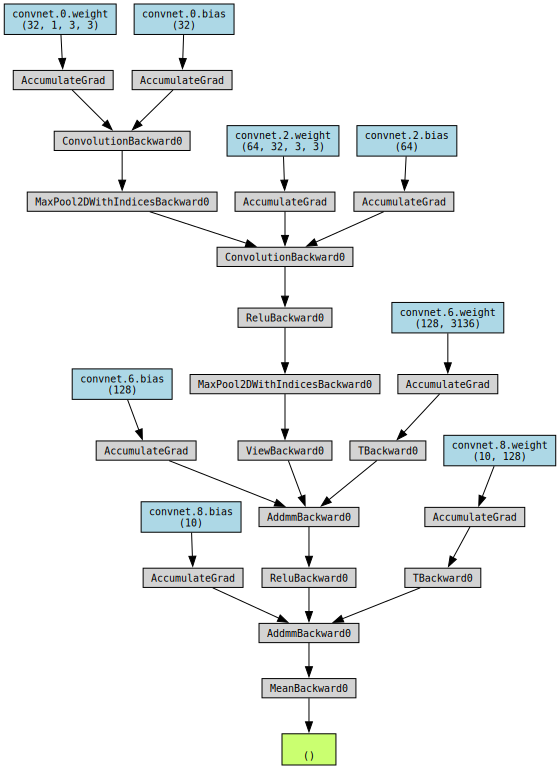

In [16]:
make_dot(pred_labels.mean(), params=dict(model.named_parameters()))